# Performance testing analysis

### Library functions: loading

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd

RESULTS_ROOT = Path(".")

def infer_alg_from_filename(path: Path) -> str:
    return path.stem.split("-")[-1].lower()


def load_metadata(run_dir: Path) -> dict:
    json_path = run_dir / "metadata.json"
    if json_path.exists():
        return json.loads(json_path.read_text(encoding="utf-8"))
    return {}


def get_metric(metrics: dict, name: str, key: str, default=np.nan):
    m = metrics.get(name)
    return default if m is None else m.get(key, default)


rows = []

for run_dir in sorted(RESULTS_ROOT.glob("run-*")):
    if not run_dir.is_dir():
        continue

    meta = load_metadata(run_dir)

    for p in sorted(run_dir.glob("*.json")):
        if p.name == "metadata.json":
            continue
        
        data = json.loads(p.read_text())
        m = data["metrics"]
        alg = infer_alg_from_filename(p)

        rows.append({
            "run": run_dir.name,
            "title":  meta.get("title"),
            "cpu":    meta.get("cpu"),
            "ram":    meta.get("ram"),
            "ssd":    meta.get("ssd"),
            "limits": meta.get("limits"),
    
            "alg": alg,
            "file": p.name,
            "http_reqs_rate": get_metric(m, "http_reqs", "rate", np.nan),
            "lat_avg":        get_metric(m, "http_req_duration", "avg", np.nan),
            "lat_p95":        get_metric(m, "http_req_duration", "p(95)", np.nan),
        })

df = pd.DataFrame(rows)
df["efficiency_score"] = df["http_reqs_rate"] / df["lat_avg"]
df = df.sort_values(["run", "alg", "file"]).reset_index(drop=True)


### Librray functions: plotting

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

def annotate_bars(ax, fmt="%.1f", fontsize=9, padding=3):
    for container in ax.containers:
        ax.bar_label(container, fmt=fmt, padding=padding, fontsize=fontsize)

def plot_run(df_all: pd.DataFrame, run_name: str):
    df_run = df_all[df_all["run"] == run_name].copy()
    if df_run.empty:
        print(f"No data for run={run_name}")
        return

    # порядок алгоритмов по убыванию http_reqs_rate
    alg_order = (
        df_run.groupby("alg")["http_reqs_rate"]
              .mean()
              .sort_values(ascending=False)
              .index
              .tolist()
    )

    # стабильная палитра
    palette = sns.color_palette("tab10", n_colors=len(alg_order))
    alg_palette = dict(zip(alg_order, palette))

    title = df_run["title"].iloc[0]
    limits = df_run["limits"].iloc[0]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    fig.suptitle(f"{title} ({run_name})\nLimits: {limits}", fontsize=14)

    # 1) Requests rate
    ax = axes[0, 0]
    sns.barplot(
        data=df_run,
        x="alg",
        y="http_reqs_rate",
        order=alg_order,
        hue="alg",
        hue_order=alg_order,
        palette=alg_palette,
        legend=False,
        ax=ax,
    )
    annotate_bars(ax, fmt="%.1f")
    ax.set_title("Requests rate by algorithm")
    ax.set_xlabel("Algorithm")
    ax.set_ylabel("http_reqs_rate")

    # 2) p95 latency
    ax = axes[0, 1]
    sns.barplot(
        data=df_run,
        x="alg",
        y="lat_p95",
        order=alg_order,
        hue="alg",
        hue_order=alg_order,
        palette=alg_palette,
        legend=False,
        ax=ax,
    )
    annotate_bars(ax, fmt="%.1f")
    ax.set_title("p95 latency by algorithm")
    ax.set_xlabel("Algorithm")
    ax.set_ylabel("lat_p95 (ms)")

    # 3) Efficiency score
    ax = axes[1, 0]
    sns.barplot(
        data=df_run,
        x="alg",
        y="efficiency_score",
        order=alg_order,
        hue="alg",
        hue_order=alg_order,
        palette=alg_palette,
        legend=False,
        ax=ax,
    )
    annotate_bars(ax, fmt="%.3f")
    ax.set_title("Efficiency score (rate / avg latency)")
    ax.set_xlabel("Algorithm")
    ax.set_ylabel("efficiency_score")

    # 4) Scatter: throughput vs p95 latency
    ax = axes[1, 1]
    sns.scatterplot(
        data=df_run,
        x="lat_p95",
        y="http_reqs_rate",
        hue="alg",
        hue_order=alg_order,
        palette=alg_palette,
        s=120,
        ax=ax,
    )
    ax.set_title("Throughput vs p95 latency")
    ax.set_xlabel("lat_p95 (ms)")
    ax.set_ylabel("http_reqs_rate")

    plt.show()


Matplotlib is building the font cache; this may take a moment.


### Test results

In [3]:
sorted(df["run"].unique())

['run-macmini-m4-1cpu-1gb', 'run-xeon-1cpu-1gb', 'run-xeon-unlimited']

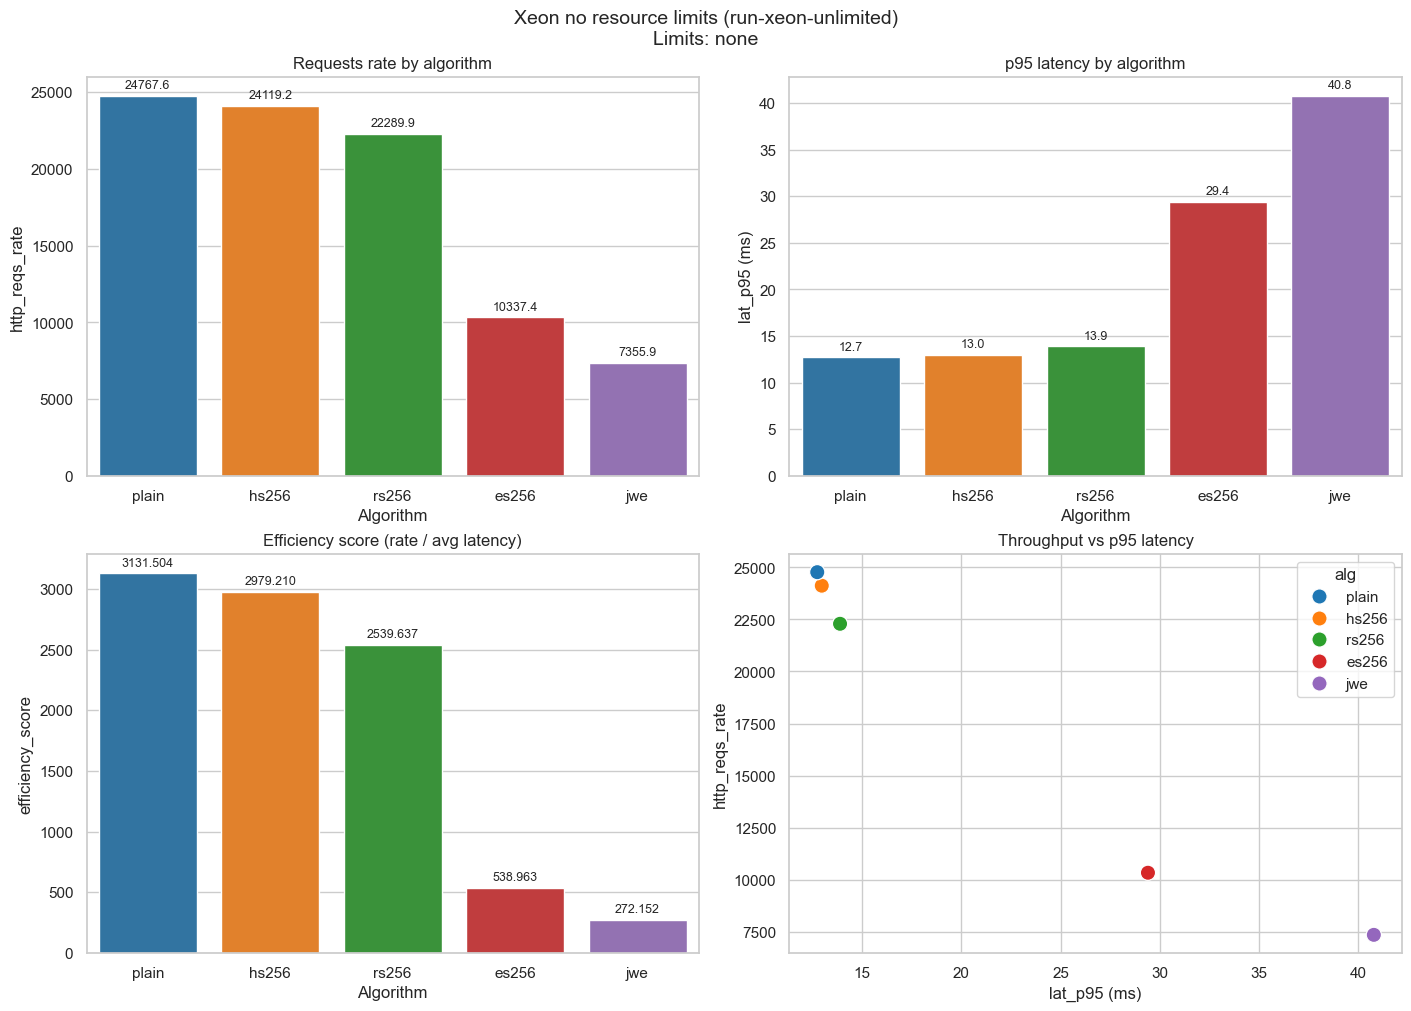

In [4]:
plot_run(df, "run-xeon-unlimited")

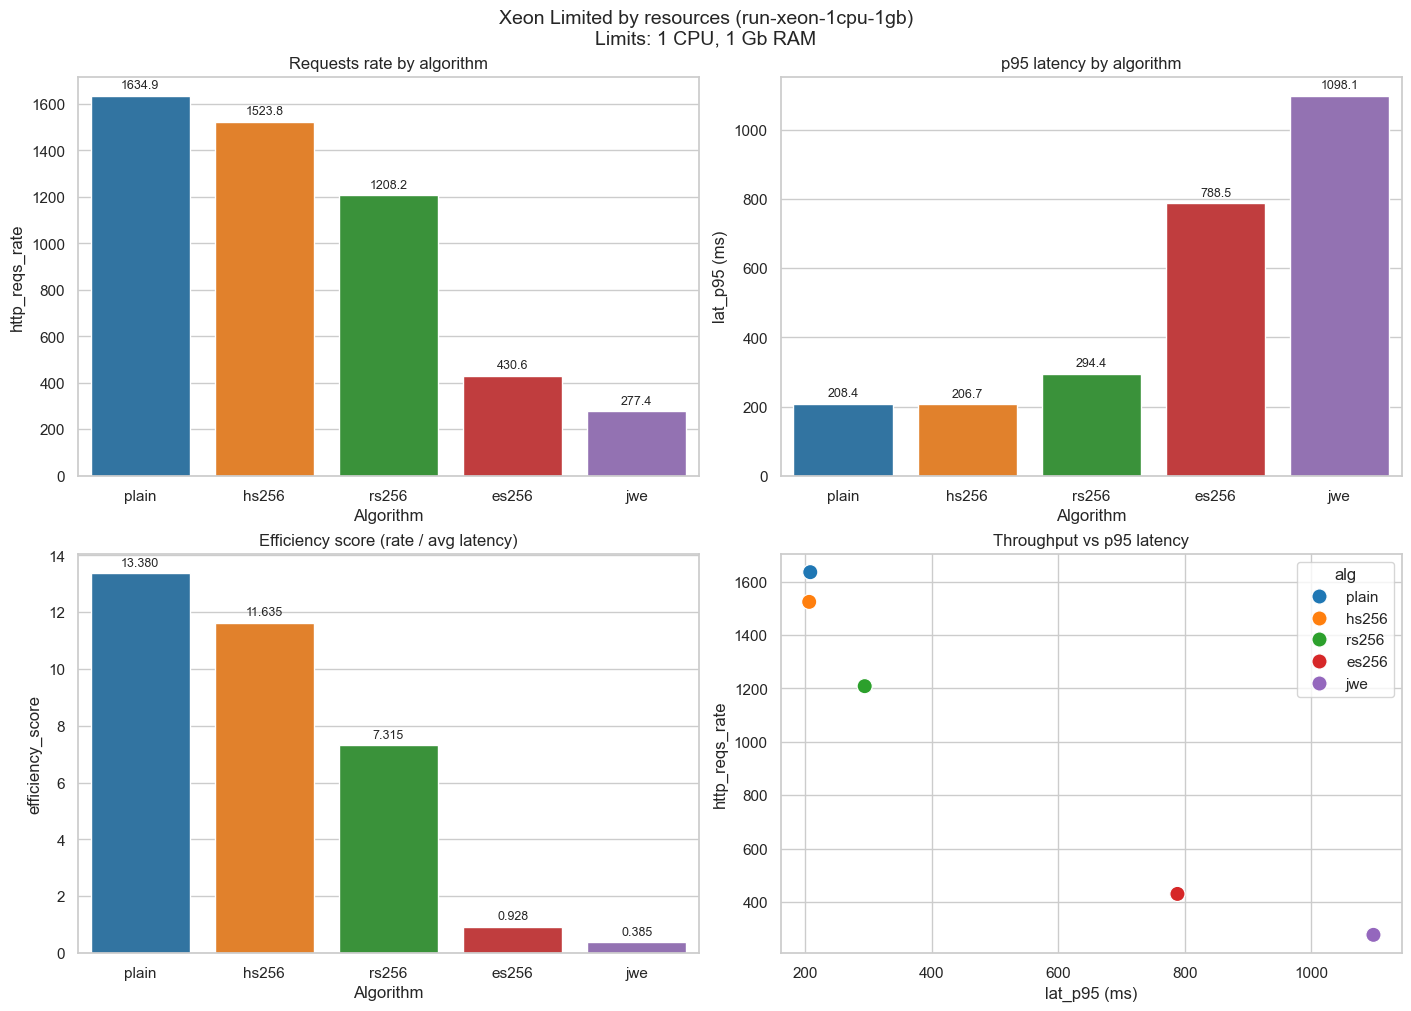

In [5]:
plot_run(df, "run-xeon-1cpu-1gb")

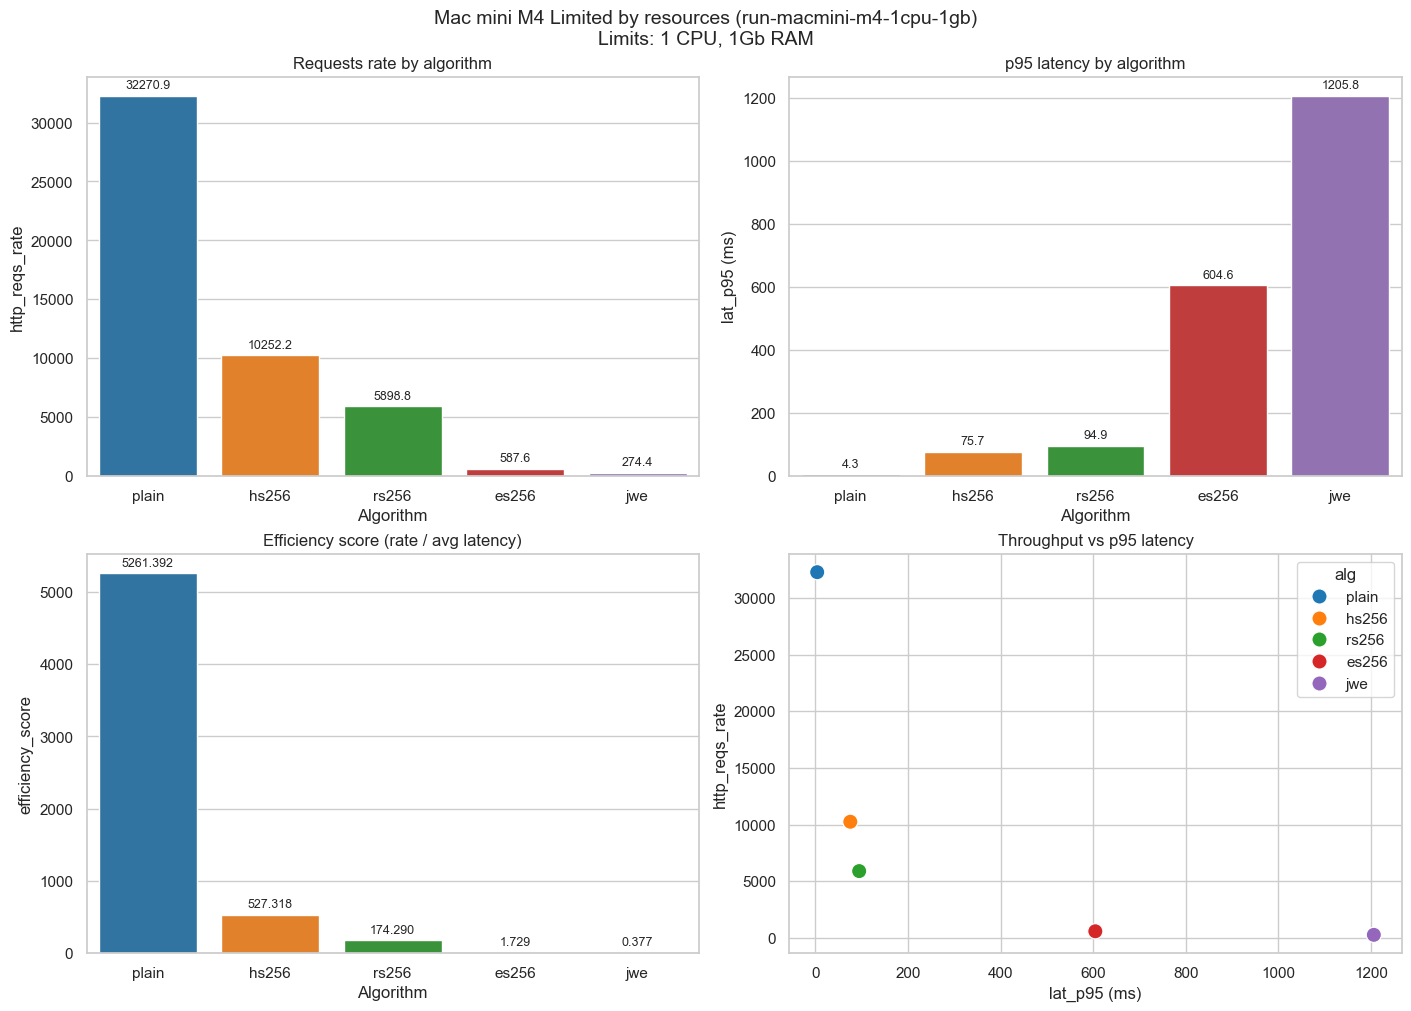

In [6]:
plot_run(df, "run-macmini-m4-1cpu-1gb")